In [3]:
!pip install shapely

In [4]:
import jax.numpy as jnp
import jax.ops as ops
from jax import grad, jit, vmap
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import numpy as np

## Define my own function and differentiate it:

In [5]:
# Differentiate 2nd order polynomial, scalar
def my_quad(x, p):
  assert len(p) == 3
  return p[0] + p[1]*x + p[2]*x**2

x = 1.0
p = jnp.array([1.0,2.0,3.0])
y = my_quad(x,p)
my_lin = grad(my_quad)
dydx = my_lin(x,p)

print(f'quadratic equation, y = p0 + p1*x + p2*x^2\nfor x = {x:.2f}, p = {p}:')
print(f'\ty = {y:.2f}\n\tdydx = {dydx:.2f}')

quadratic equation, y = p0 + p1*x + p2*x^2
for x = 1.00, p = [1. 2. 3.]:
	y = 6.00
	dydx = 8.00


## Vectorize my function and its derivative using `vmap`

In [6]:
# Differentiate 2nd order polynomial, vector
x_vec = jnp.arange(0.0, 1.2, 0.2)
y_vec = vmap(my_quad, in_axes=(0,None))(x_vec, p)
dydx_vec = vmap(my_lin, in_axes=(0,None))(x_vec, p)

print(f'Using y and p as defined above\nfor x = {x_vec}:')
print(f'\ty =    {y_vec}')
print(f'\tdydx = {dydx_vec}')

Using y and p as defined above
for x = [0.  0.2 0.4 0.6 0.8 1. ]:
	y =    [1.        1.52      2.28      3.2800002 4.52      6.       ]
	dydx = [2.        3.2       4.4       5.6000004 6.8       8.       ]


In [7]:
jnp.diff(jnp.array([0.1,0.2,0.5]))

Array([0.1, 0.3], dtype=float32)

In [12]:
def f1(theta):
  x = 5*jnp.power(jnp.cos(theta), 3)
  y = 5*jnp.power(jnp.sin(theta), 3)
  return x, y

def f2(theta):
  x = 16*jnp.power(jnp.sin(theta), 3)
  y = 13*jnp.cos(theta) - 5 * jnp.cos(2*theta) - 2*jnp.cos(3*theta) - jnp.cos(4*theta)
  return x, y

param_f = f1
from sympy import *
from sympy.geometry import *
from sympy.abc import t
Curve((5*cos(t)**3, 5*sin(t)**3), (t, 0, 2*pi)).length / 10

3

In [9]:
def hbar(theta, param_f):
  x, y = param_f(theta)
  xdiff = jnp.diff(x)
  ydiff = jnp.diff(y)
  h = jnp.sqrt(jnp.add(jnp.power(xdiff, 2), jnp.power(ydiff, 2)))
  hbar_final = jnp.average(h)
  return hbar_final

def loss(theta, param_f):
  x, y = param_f(theta)
  xdiff = jnp.diff(x)
  ydiff = jnp.diff(y)
  h = jnp.sqrt(jnp.add(jnp.power(xdiff, 2), jnp.power(ydiff, 2)))
  # print("h", len(h), h)
  hbar = jnp.average(h)
  # print("hbar", hbar.val)
  r = jnp.divide(jnp.subtract(h, hbar), hbar)
  # print("r", r)
  err = jnp.sum(jnp.square(r)) / 2
  # print(err.val)
  return err

dEdtheta = grad(loss)

def plot_curve(param_f):
  ax = plt.figure().add_subplot()
  # ax.set_ylim(-6, 6)
  # ax.set_xlim(-6, 6)

  # Prepare arrays x, y, z
  theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
  x, y = param_f(theta)

  ax.plot(x, y, label='parametric curve')
  ax.legend()

  plt.show()

def plot_points(theta, param_f):
  # ax = plt.figure().add_subplot()
  # ax.set_ylim(-6, 6)
  # ax.set_xlim(-6, 6)

  # Prepare arrays x, y, z
  curve_t = np.linspace(0, 2 * np.pi, 100)
  x, y = param_f(curve_t)

  plt.plot(x, y, label='parametric curve', color="#000000")
  plt.legend()

  x, y = param_f(theta)
  plt.scatter(x,y, color="#dd4b3d")
  # Label points
  numpoints=len(x)
  for ind, (i, j) in enumerate(zip(x, y)):
    if ind != numpoints-1:
      plt.text(i, j, ind)
  plt.show()


In [10]:
def run_opt(param_f, nr, steps):
  theta = jnp.linspace(0, 2*jnp.pi, nr)
  plot_curve(param_f)
  plot_points(theta, param_f)
  for _ in range(steps):
    theta -= 0.01*dEdtheta(theta, param_f)
    # plot_points(theta, param_f)
  plot_points(theta, param_f)
  return theta, hbar(theta, param_f)

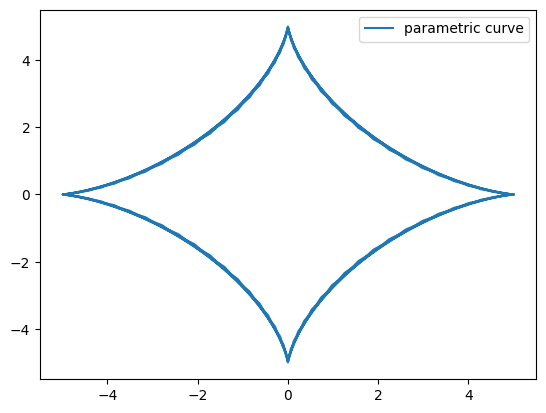

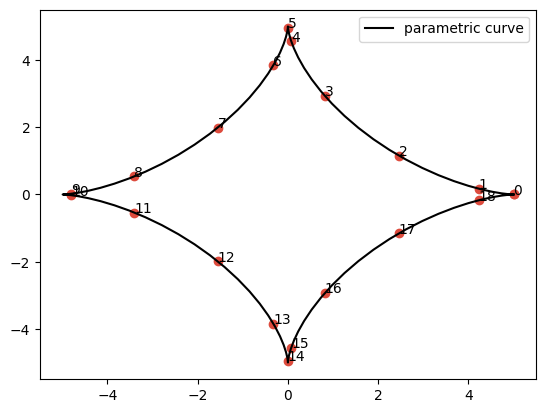

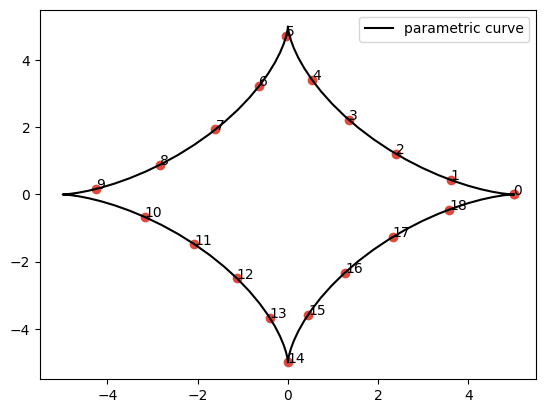

In [13]:
final_thetas, final_hbar = run_opt(param_f, 20, 200)

In [ ]:
from shapely.geometry import Polygon
x, y = f2(final_thetas)
pgon = Polygon(zip(x, y)) # Assuming the OP's x,y coordinates

print(pgon.area)

549.7716580484181


In [ ]:
area_enclosed = []
area_pattern = []
for i in range(3,21):
  print(i)
  final_thetas, final_hbar = run_opt(param_f, i, 500)
  x, y = f2(final_thetas)
  pgon = Polygon(zip(x, y)) # Assuming the OP's x,y coordinates

  area_enclosed.append(pgon.area)
  area_pattern.append((i/4) * final_hbar**2)

print(area_enclosed)
print(area_pattern)

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
[9.407548306396826e-19, 97.7105079432979, 228.09712314605713, 308.477741838498, 413.5913539474118, 415.7324146378351, 479.3340994326577, 469.77655245666534, 510.3370789411799, 498.3241604018201, 527.0445348361588, 515.8157541689054, 537.2016637044237, 527.1688054543713, 543.8095746865869, 535.0416973333143, 548.3642923181187, 549.6272581798898]
[Array(363., dtype=float32), Array(225.65276, dtype=float32), Array(285.75494, dtype=float32), Array(376.25174, dtype=float32), Array(393.44415, dtype=float32), Array(307.60495, dtype=float32), Array(319.41467, dtype=float32), Array(254.39609, dtype=float32), Array(263.47162, dtype=float32), Array(212.89575, dtype=float32), Array(221.76271, dtype=float32), Array(182.80098, dtype=float32), Array(190.97264, dtype=float32), Array(159.87544, dtype=float32), Array(167.38351, dtype=float32), Array(142.03882, dtype=float32), Array(148.86263, dtype=float32), Array(139.89392, dtype=float32)]


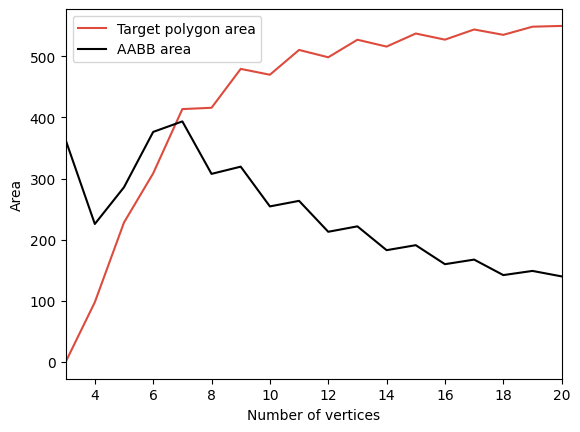

In [ ]:
plt.plot(range(3,21), area_enclosed, label="Target polygon area", color="#dd4b3d")
plt.plot(range(3,21), area_pattern, label="AABB area", color="#000000")
plt.xlim((3, 20))
plt.xlabel("Number of vertices")
plt.ylabel("Area")
plt.legend()
plt.show()